kernel restartに時間がかかる時; disable jupyter-> reload the window -> enable jupyter on extention

In [1]:
# # このセルは毎回実行しなくても大丈夫
# !wget https://bootstrap.pypa.io/get-pip.py
# !python get-pip.py
# %pip install tokenizers fugashi ipadic accelerate==0.20.3 japanize-matplotlib jupyter transformers datasets matplotlib scikit-learn seaborn
# !wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
# %pip install japanize-matplotlib scikit-learn seaborn ipykernel
# %pip install tensorflow -> needs refreshing the window
# %python -m pip install ipykernel


In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語フォントを有効にする
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pickle
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AdamW, get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
from datasets import Dataset, load_metric
from transformers import PushToHubCallback


2024-02-01 11:47:46.531625: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 11:47:46.557830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 11:47:46.557869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 11:47:46.558656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 11:47:46.563020: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 11:47:46.563930: I tensorflow/core/platform/cpu_feature_guard.cc:1

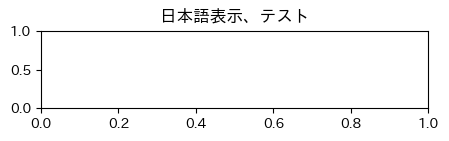

In [3]:
# 動作確認
plt.figure(figsize=(5, 1))
plt.title('日本語表示、テスト')
plt.show()

In [4]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)


,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


In [5]:
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']
num_labels = len(emotion_names)
# objective emotion average (Avg. Readers_*) values are converted to list, defined as a new column
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)
# removing samples with less emotion intensities
# (max.readers_emotion_intensities must be 2 or more)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [6]:
# divide into train and test data
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


In [7]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [8]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', return_tensors="pt")
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)


Parameter 'function'=<function tokenize_function at 0x7ff219e7eb90> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [9]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

/tmp/ipykernel_3010/2193463291.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [10]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# %pip install accelerate transformers[torch] -U
# # error → 上のコードを実行して、仮想環境をdeactivate -> restart vscode -> run all the cells againで解決
# # ssh接続中の場合は、Restartからカーネル再起動で解決


In [12]:
# Transformers の Trainer を用いる
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments
# 訓練時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8, 
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する
# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)
# 訓練を実行
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,No log,0.274144,0.566637
400,No log,0.247724,0.631951
600,0.301300,0.233043,0.680494
800,0.301300,0.222472,0.712268
1000,0.262900,0.216783,0.726390
1200,0.262900,0.218558,0.713151
1400,0.262900,0.213837,0.729038
1600,0.248900,0.210392,0.734334
1800,0.248900,0.206572,0.744925
2000,0.242200,0.206453,0.751103


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=2138, training_loss=0.26189093594243307, metrics={'train_runtime': 317.9383, 'train_samples_per_second': 53.797, 'train_steps_per_second': 6.725, 'total_flos': 4500493926531072.0, 'train_loss': 0.26189093594243307, 'epoch': 1.0})

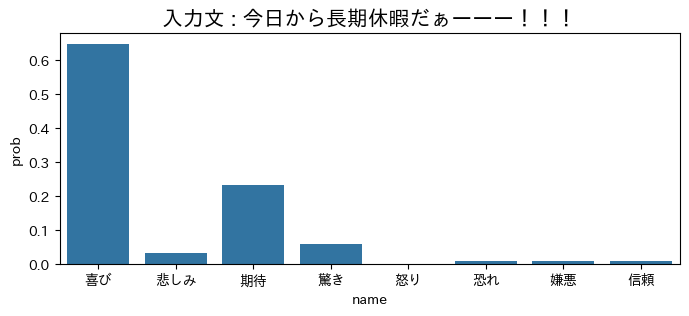

In [13]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x
def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()
    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}
    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)
    if ret_prob:
        return out_dict
# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [17]:
model.save_pretrained("/workspace/model_training.bin")

In [18]:
!pwd

/
